## 固有顔による特徴量抽出


### Labeled Faces in the Wild 顔認識データセット
--------------------------------------------------

このデータセットは、有名人のJPEG画像をインターネットから収集したもので、詳細はKaggleのウェブサイトに掲載されています：  
https://www.kaggle.com/datasets/jessicali9530/lfw-dataset

各画像は1人の顔を中心にトリミングされています。典型的なタスクは **顔照合 (Face Verification)** です。  
つまり、2枚の画像が与えられたときに、それが同一人物かどうかを二値分類器で予測します。  

もう1つのタスクは **顔認識 (Face Recognition / Face Identification)** です。  
未知の人物の顔画像が与えられたときに、過去に見たことのある人物のギャラリーを参照して、その人物の名前を特定します。  

顔照合や顔認識はいずれも、まず **顔検出 (Face Detection)** を行ったモデルの出力を利用するのが一般的です。  
もっとも有名な顔検出モデルは **Viola-Jones** で、OpenCVライブラリに実装されています。LFWの顔画像も、様々なウェブサイトからこの検出器を用いて抽出されました。

---

#### データセットの特徴

| 特性              | 値                         |
|-------------------|----------------------------|
| クラス数          | 5749                       |
| 総サンプル数      | 13233                      |
| 次元数            | 5828                       |
| 特徴量            | 実数値（0〜255の範囲）     |

---

#### 使用方法

`scikit-learn` は2つのローダーを提供しており、これを使うと自動的にダウンロード・キャッシュ・メタデータ解析・JPEGのデコードを行い、NumPy配列に変換してくれます。データサイズは200MBを超えるため、最初のロードには数分かかります。ただし、一度読み込んだ後はメモリマップされたキャッシュを利用することで、次回以降は200ms未満で読み込めます（保存先は `~/scikit_learn_data/lfw_home/` フォルダ、`joblib` を利用）。

1. **顔認識 (Face Identification)** 用ローダー：多クラス分類タスク（教師あり学習）

```python
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

for name in lfw_people.target_names:
    print(name)
```
例: Ariel Sharon, Colin Powell, Donald Rumsfeld, George W Bush, Gerhard Schroeder, Hugo Chavez, Tony Blair

デフォルトの画像スライスは顔の周辺を切り抜いており、背景はほとんど除去されています。

```python
lfw_people.data.dtype
# dtype('float32')

lfw_people.data.shape
# (1288, 1850)

lfw_people.images.shape
# (1288, 50, 37)

lfw_people.target.shape
# (1288,)

list(lfw_people.target[:10])
# [5, 6, 3, 1, 0, 1, 3, 4, 3, 0]
```

2. **顔照合 (Face Verification)** 用ローダー：各サンプルは2枚の画像ペア

```python
from sklearn.datasets import fetch_lfw_pairs
lfw_pairs_train = fetch_lfw_pairs(subset='train')

list(lfw_pairs_train.target_names)
# ['Different persons', 'Same person']

lfw_pairs_train.pairs.shape
# (2200, 2, 62, 47)

lfw_pairs_train.data.shape
# (2200, 5828)

lfw_pairs_train.target.shape
# (2200,)
```

どちらの関数（`fetch_lfw_people`, `fetch_lfw_pairs`）も、`color=True` を指定すればRGBチャンネル付きで読み込むことができます。この場合の形状は `(2200, 2, 62, 47, 3)` となります。  
さらに `fetch_lfw_pairs` のデータは `train` セット、`test` セット、10分割交差検証用の `10_folds` セットに分割されています。

---

#### 参考文献

- [Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments.](https://people.cs.umass.edu/~elm/papers/lfw.pdf)  
  Gary B. Huang, Manu Ramesh, Tamara Berg, and Erik Learned-Miller.  
  University of Massachusetts, Amherst, Technical Report 07-49, October 2007.

---

#### 例

- :ref:`sphx_glr_auto_examples_applications_plot_face_recognition.py`


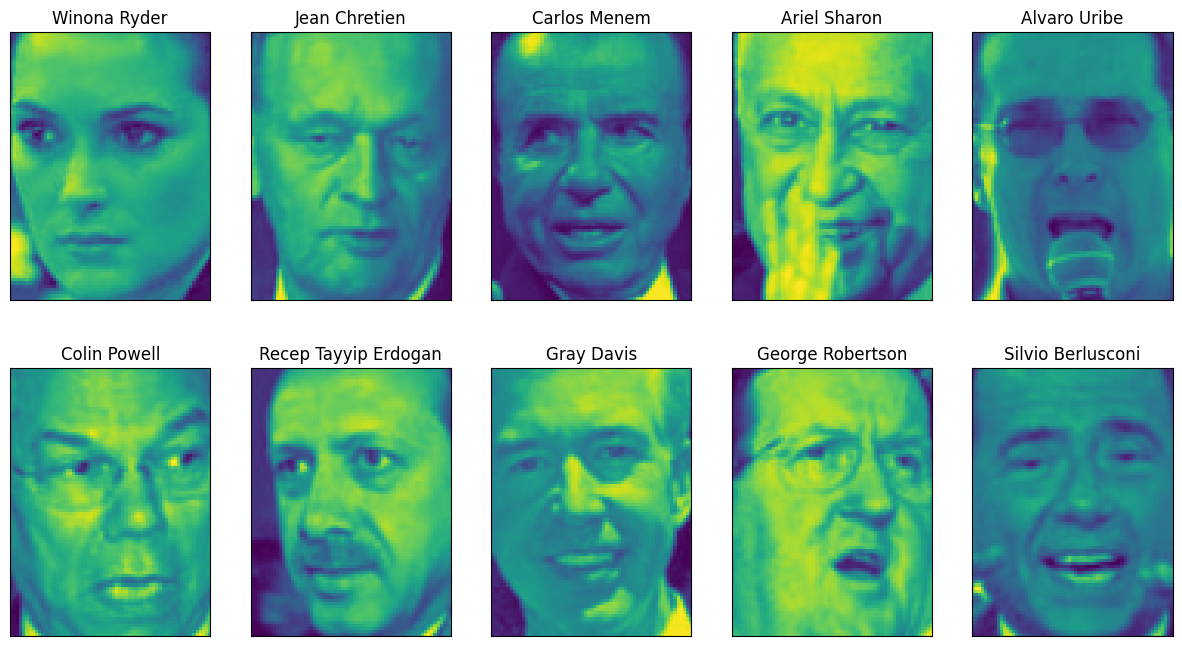

In [5]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fix, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={"xticks": [], "yticks": []})

for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])
plt.show()

In [6]:
print(f"people.images.shape: {people.images.shape}")
print(f"Number of classes: {len(people.target_names)}")

people.images.shape: (3023, 87, 65)
Number of classes: 62


87x65 の画像が3023枚あり、クラスは６２。つまり６２人いる。

In [7]:
import numpy as np

# 各ターゲットの出現数をカウントする
counts = np.bincount(people.target)

# ターゲット名とその出現数を表示する
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print(f"{i:2d} {name:25s} {count:3d}", end="   ")
    if (i + 1) % 3 == 0:
        print()

 0 Alejandro Toledo           39    1 Alvaro Uribe               35    2 Amelie Mauresmo            21   
 3 Andre Agassi               36    4 Angelina Jolie             20    5 Ariel Sharon               77   
 6 Arnold Schwarzenegger      42    7 Atal Bihari Vajpayee       24    8 Bill Clinton               29   
 9 Carlos Menem               21   10 Colin Powell              236   11 David Beckham              31   
12 Donald Rumsfeld           121   13 George Robertson           22   14 George W Bush             530   
15 Gerhard Schroeder         109   16 Gloria Macapagal Arroyo    44   17 Gray Davis                 26   
18 Guillermo Coria            30   19 Hamid Karzai               22   20 Hans Blix                  39   
21 Hugo Chavez                71   22 Igor Ivanov                20   23 Jack Straw                 28   
24 Jacques Chirac             52   25 Jean Chretien              55   26 Jennifer Aniston           21   
27 Jennifer Capriati          42   28 Jennifer

出現回数が多いやつがいるので、そうしないとそいつに偏るから。

In [8]:
mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
Y_people = people.target[mask]
X_people = X_people / 255.0

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X_people, Y_people, stratify=Y_people, random_state=0
)
# 1-最近傍法
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, Y_train)
print(f"Test set score: {knn.score(X_test, Y_test):.3f}")

Test set score: 0.215


↑主成分分析使わない場合の精度。そんなに良くない。

#### whitenedオプション付きで主成分分析した図

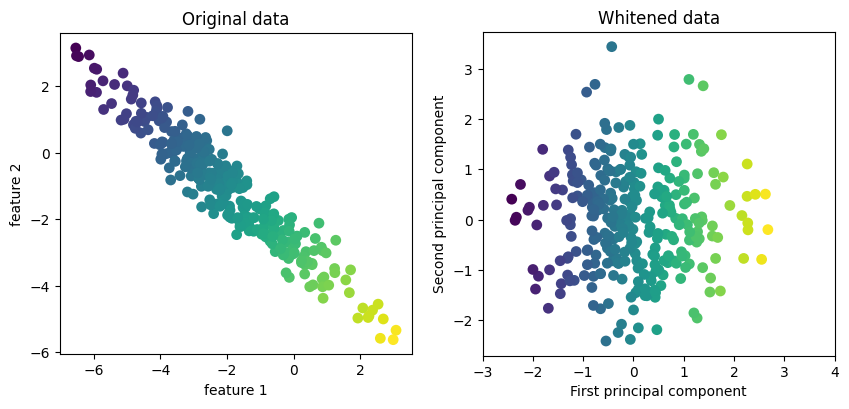

In [10]:
import mglearn

mglearn.plots.plot_pca_whitening()

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(f"X_train_pca.shape: {X_train_pca.shape}")

X_train_pca.shape: (1547, 100)


In [12]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, Y_train)
print(f"Test set score: {knn.score(X_test_pca, Y_test):.3f}")

Test set score: 0.297


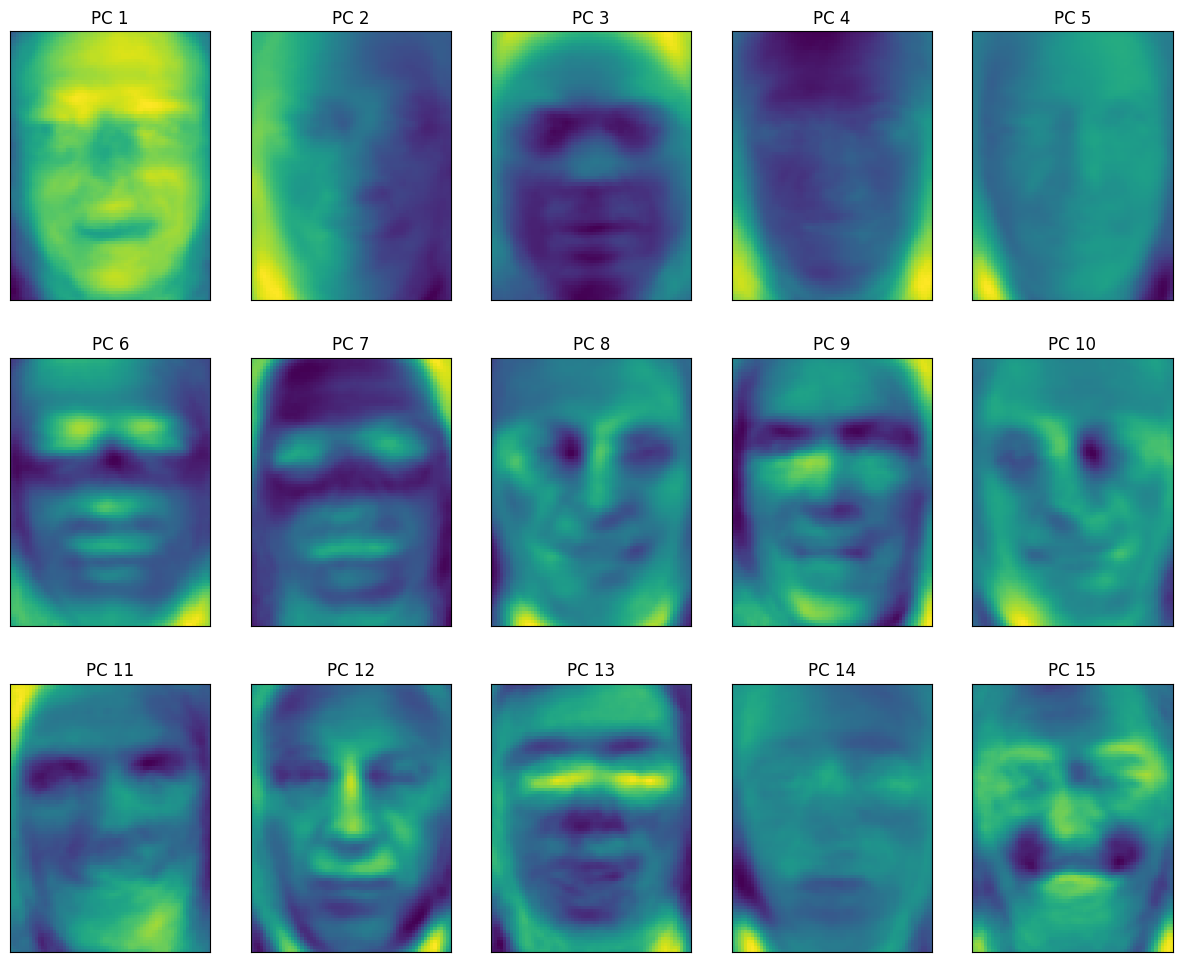

In [13]:
fix, axes = plt.subplots(
    3, 5, figsize=(15, 12), subplot_kw={"xticks": [], "yticks": []}
)
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap="viridis")
    ax.set_title(f"PC {i+1}")
plt.show()

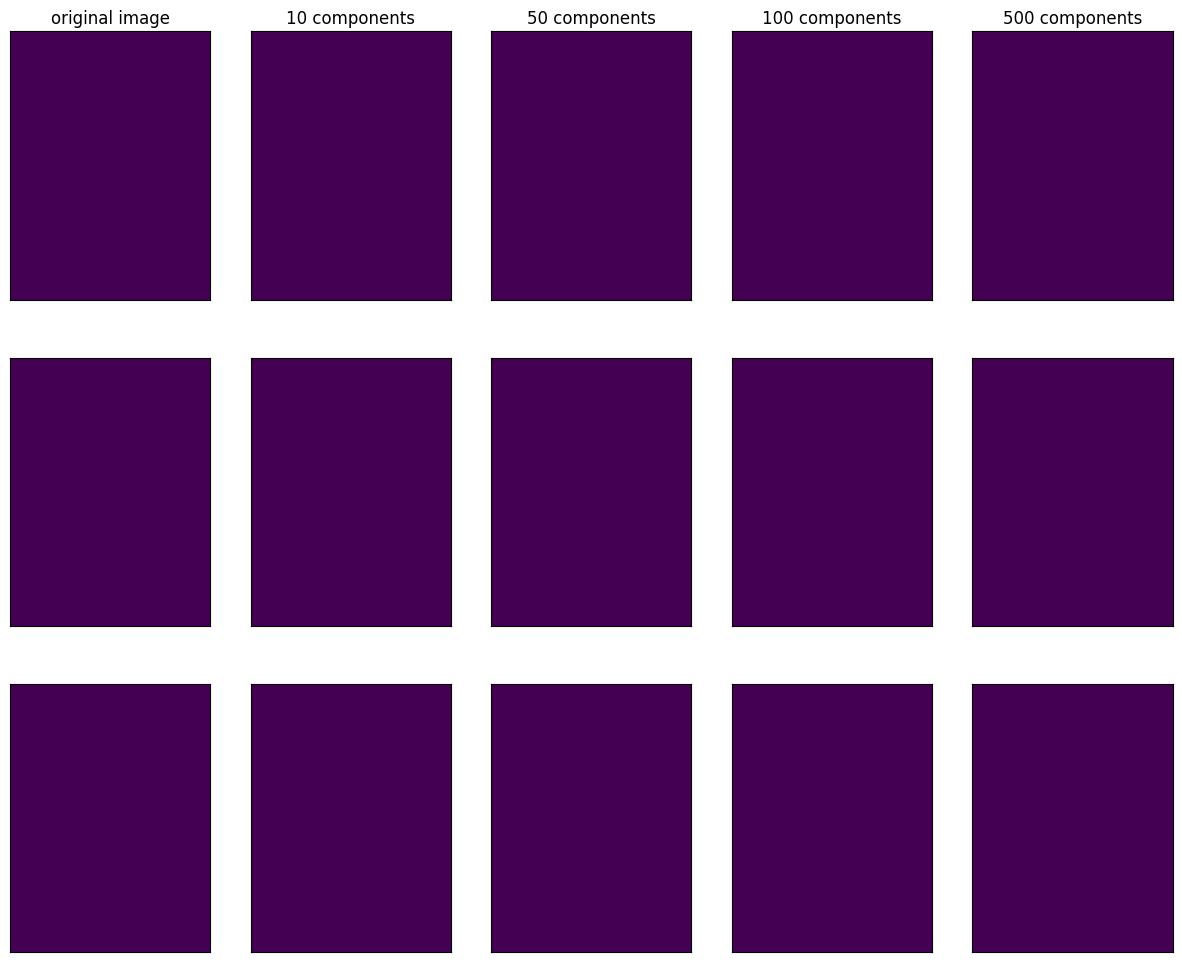

In [14]:
mglearn.plots.plot_pca_faces(X_train=X_train, X_test=X_test, image_shape=image_shape)

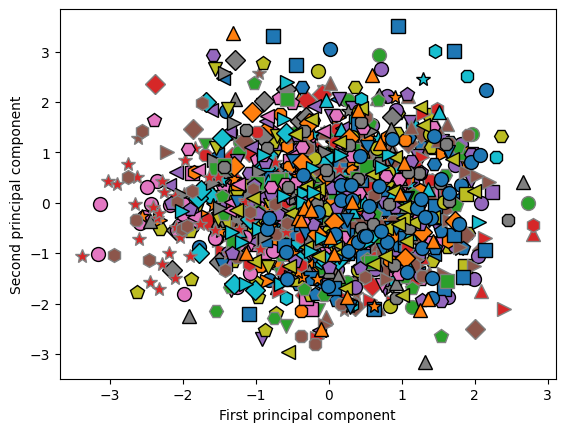

In [15]:
mglearn.discrete_scatter(X_train_pca[:, 0], X_train_pca[:, 1], Y_train)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

/home/dev/.local/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


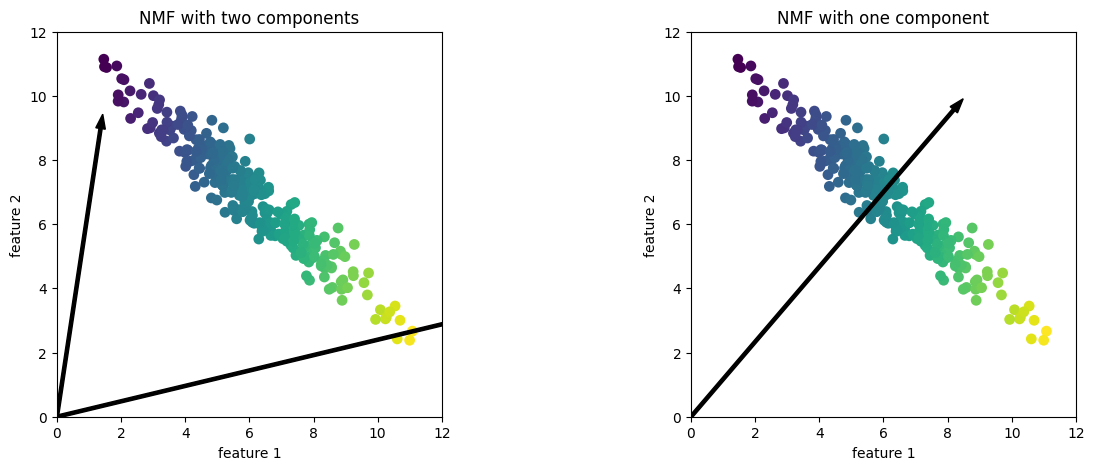

In [16]:
mglearn.plots.plot_nmf_illustration()

/home/dev/.local/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


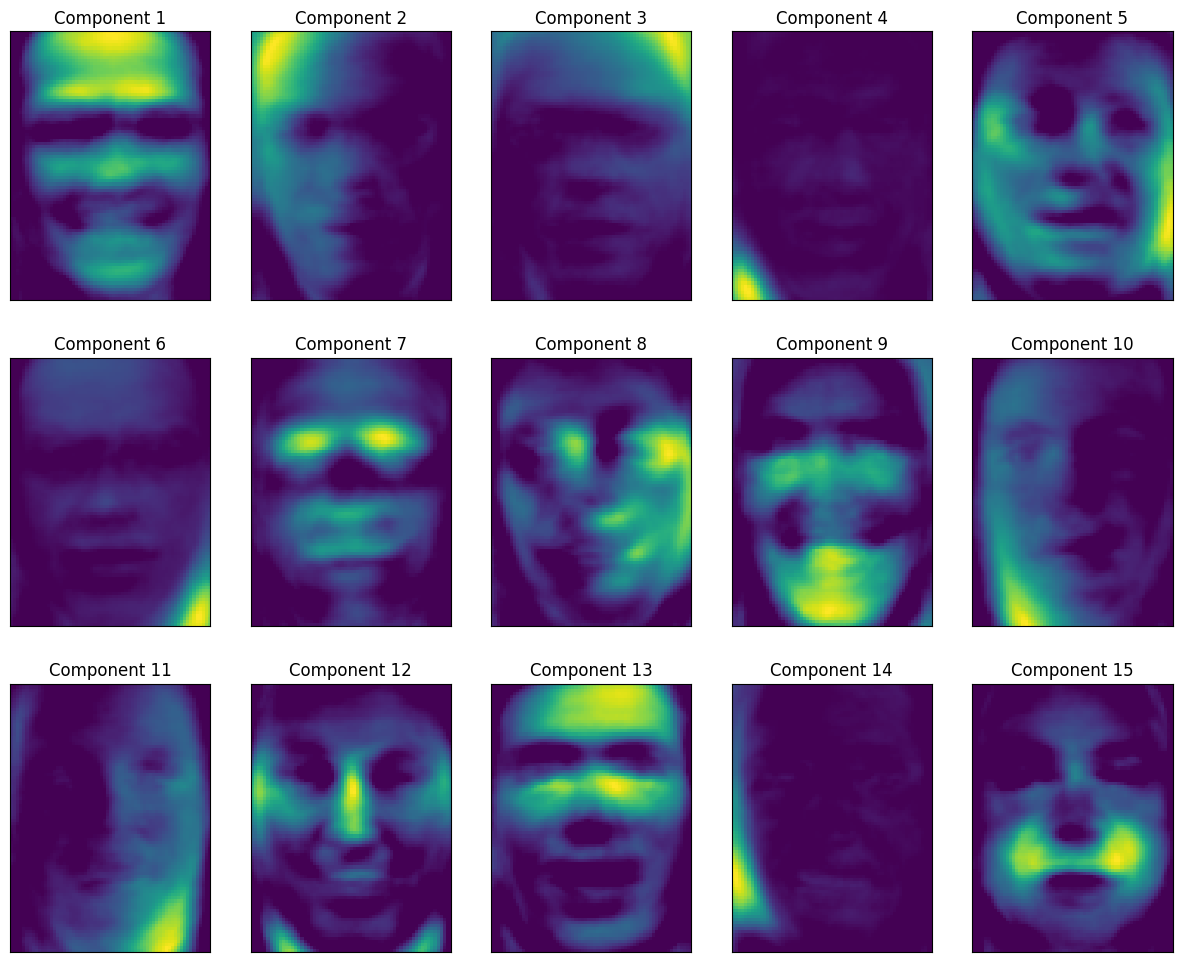

In [18]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)

X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fix, axes = plt.subplots(
    3, 5, figsize=(15, 12), subplot_kw={"xticks": [], "yticks": []}
)
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap="viridis")
    ax.set_title(f"Component {i+1}")
plt.show()